<left>FINM 33150 - Quantitative Trading Strategies</left>
<left>Winter 2023</left>
<br>
<h1><center> Homework 2: Simple Spread Trading </center></h1>
<center>Due - 23:00 [CST] January 19th, 2023</center>
<br>
<h3>Ki Hyun</h3>
<h3>Student ID: 12125881</h3>

<h5> Imports </h5>

In [1]:
%matplotlib inline

In [2]:
import os
from datetime import datetime, timedelta
import quandl
import functools

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns

<h5> Constants </h5>

In [3]:
EOD_Prices_Header = 'QUOTEMEDIA/PRICES'
X_pair = 'RYE'
Y_pair = 'XOP'
start_date = '2020-12-02'
end_date = '2022-11-15'
Fama_French_dir = r'C:\Users\kwhyu\OneDrive - The University of Chicago\2023-1 Winter\FINM 33150\FINM-33150-W23\Data' +\
              r'\Fama-French\Developed_3_Factors_Daily_CSV.zip'
train_dates = ['2020-12-02','2021-12-01']

<h5> Helper Functions </h5>

In [4]:
"""
This code was given by Dr. Boonstra, B., Ph.D. for
University of Chicago FINM 33150 Quandl Options Data Fetching guidelines
"""
def grab_quandl_table(
    table_path,
    avoid_download=False,
    replace_existing=False,
    date_override=None,
    allow_old_file=False,
    **kwargs,
):
    root_data_dir = r'C:\Users\kwhyu\OneDrive - The University of Chicago\2023-1 Winter\FINM 33150\FINM-33150-W23\Data'
    data_symlink = os.path.join(root_data_dir, table_path.split("/")[0], (table_path.split("/")[1] + "_latest.zip"))
    if avoid_download and os.path.exists(data_symlink):
        print(f"Skipping any possible download of {table_path}")
        return data_symlink

    table_dir = os.path.dirname(data_symlink)
    if not os.path.isdir(table_dir):
        print(f'Creating new data dir {table_dir}')
        os.mkdir(table_dir)

    if date_override is None:
        my_date = datetime.now().strftime("%Y%m%d")
    else:
        my_date = date_override

    #print('Data_file')
    data_file = os.path.join(root_data_dir, table_path.split("/")[0], (table_path.split("/")[1] + f"_{my_date}.zip"))

    if os.path.exists(data_file):
        file_size = os.stat(data_file).st_size
        if replace_existing or not file_size > 0:
            print(f"Removing old file {data_file} size {file_size}")
        else:
            print(
                f"Data file {data_file} size {file_size} exists already, no need to download"
            )
            return data_file

    #print('quandl.export_table')
    dl = quandl.export_table(
        table_path, filename=data_file, api_key='JbMPn9bSpFPNS7Z7PcZy', **kwargs
    )
    #print('quandl.export_table finished')
    file_size = os.stat(data_file).st_size
    if os.path.exists(data_file) and file_size > 0:
        print(f"Download finished: {file_size} bytes")
        if not date_override:
            if os.path.exists(data_symlink):
                print(f"Removing old symlink")
                os.unlink(data_symlink)
            print(f"Creating symlink: {data_file} -> {data_symlink}")
            os.symlink(
                data_file, data_symlink,
            )
    else:
        print(f"Data file {data_file} failed download")
        return
    return data_symlink if (date_override is None or allow_old_file) else "NoFileAvailable"

In [5]:
"""
This code was given by Dr. Boonstra, B., Ph.D. for
University of Chicago FINM 33150 Quandl Options Data Fetching guidelines
"""
def fetch_quandl_table(table_path, avoid_download=True, **kwargs):
    return pd.read_csv(
        grab_quandl_table(table_path, avoid_download=avoid_download, **kwargs)
    )

In [6]:
def clean_prices_df(prices_df, X_pair, Y_pair, start_date, end_date):
    """

    :param prices_df:
    :param X_pair:
    :param Y_pair:
    :param start_date:
    :param end_date:
    :return:
    """
    df = prices_df.copy()
    df.set_index(['ticker', 'date'], inplace = True)
    df.sort_index(inplace = True)
    X_data = df.loc[X_pair].loc[start_date:end_date][['adj_close', 'adj_volume']]\
        .rename({'adj_close': 'X_Price', 'adj_volume': r'$V_t$'}, axis = 1)
    Y_data = df.loc[Y_pair].loc[start_date:end_date][['adj_close']]\
        .rename({'adj_close':'Y_Price'}, axis = 1)
    ret_df = X_data.join(Y_data)
    ret_df[r'$N_t$'] = ret_df[r'$V_t$'].rolling(15).median()
    ret_df[r'$X^N_t$'] = (ret_df[r'$N_t$']/100 / ret_df['X_Price']).__round__(0)
    ret_df[r'$Y^N_t$'] = (ret_df[r'$N_t$']/100 / ret_df['Y_Price']).__round__(0)
    return ret_df

In [7]:
def compute_spread(df_clean, M):
    """

    :param df_clean:
    :param M:
    :return:
    """
    df = df_clean.copy()
    df[r'$r^{X, M}_t$'] = df['X_Price'] / df['X_Price'].shift(M) - 1
    df[r'$r^{Y, M}_t$'] = df['Y_Price'] / df['Y_Price'].shift(M) - 1
    df[r'$z^M_t$'] = df[r'$r^{X, M}_t$'] - df[r'$r^{Y, M}_t$']
    df = df.dropna()
    return df

In [8]:
class monthly:
    """

    """
    def __init__(self, start_date, end_date):
        self.initial = start_date
        self.terminal = end_date
        self.start = start_date
        temp = start_date.split('-')
        temp[2] = '31'
        self.end = '-'.join(temp)
        if int(start_date.split('-')[2]) > 3:
            self.lag = True
        else:
            self.lag = False
    def next_month(self):
        temp = datetime.strptime(self.start, '%Y-%m-%d') + timedelta(days = 31)
        temp =  temp.strftime('%Y-%m-%d').split('-')
        temp[2] = '01'
        self.start = '-'.join(temp)
        temp[2] = '31'
        self.end = '-'.join(temp)
        if self.start > self.terminal:
            return None
        else:
            return 1

In [9]:
def spread_trade(df_M, g, j):
    """

    :param df_M:
    :param g:
    :param j:
    :return:
    """
    df = df_M.copy()
    Order = []
    Qx = []
    Qy = []
    Gross_Cash = []
    Position = []
    dates = monthly(df.index[0], df.index[-1])
    if dates.lag:
        lagger = 0
    else:
        lagger = 1

    in_position = False

    while(lagger is not None):
        Q_x = 0
        Q_y = 0
        cash = 0
        order = 0
        sign = 1.0
        for day in df.loc[dates.start:dates.end].index:
            item = df[r'$z^M_t$'].loc[day]
            if item**2 > g**2 and not in_position:
                Q_x = df[r'$X^N_t$'].loc[day]
                Q_y = df[r'$Y^N_t$'].loc[day]
                sign = item / abs(item)
                buy = (df['Y_Price'].loc[day] * Q_y - df['X_Price'].loc[day] * Q_x) * sign
                cash = (df['Y_Price'].loc[day] * Q_y + df['X_Price'].loc[day] * Q_x) * lagger
                order = lagger*buy
                in_position = True
            elif item**2 < j**2 and in_position:
                sell = (df['Y_Price'].loc[day] * Q_y - df['X_Price'].loc[day] * Q_x) * sign
                order = -1*lagger*sell
                Q_x = 0
                Q_y = 0
                lagger = 0
                cash = 0
            else:
                order = 0.0

            Gross_Cash.append(cash)
            Order.append(order)
            Qx.append(-1*lagger*sign*Q_x)
            Qy.append(lagger*sign*Q_y)
            position = (df['Y_Price'].loc[day] * Q_y - df['X_Price'].loc[day] * Q_x) * sign * lagger
            Position.append(position)

        if in_position and lagger != 0:
            sell = (df['Y_Price'].loc[day] * Q_y - df['X_Price'].loc[day] * Q_x) * sign
            Order[-1] = -1*lagger*sell
            Qx[-1] = lagger*sign*0
            Qy[-1] = -1*lagger*sign*0
            Gross_Cash[-1] = 0.0
            Position[-1] = 0.0

        in_position = False

        lagger = dates.next_month()

    df['Order'] = Order
    df[r'$Q_X$'] = Qx
    df[r'$Q_Y$'] = Qy
    df['Gross Cash'] = Gross_Cash
    df['Position'] = Position

    return df

In [10]:
def PnL_calc(df_Quant, adjusted = False):
    """

    :param df_Quant:
    :param adjusted:
    :return:
    """
    df = df_Quant.copy()
    Daily_PL = []
    M_PL = []
    in_position = False

    if adjusted:
        position_lab = 'Adj Position'
        order_lab = 'Adj Order'
    else:
        position_lab = 'Position'
        order_lab = 'Order'

    dates = monthly(df.index[0], df.index[-1])
    if dates.lag:
        lagger = 0
    else:
        lagger = 1

    while(lagger is not None):
        initial_Position = 0.0
        yesterday_Position = 0.0
        for day in df.loc[dates.start:dates.end].index:
            position = df[position_lab].loc[day]
            order = df[order_lab].loc[day]
            Daily_PL.append(position - yesterday_Position - order)
            M_PL.append(position - initial_Position - order)

            yesterday_Position = position
            if position != 0 and not in_position:
                initial_Position = position
                in_position = True
            elif position == 0 and in_position:
                initial_Position = 0.0
                in_position = False

        lagger = dates.next_month()

    return Daily_PL, M_PL

In [11]:
def add_stopper(df_Quant, s):
    """

    :param df_Quant:
    :param s:
    :return:
    """
    df = df_Quant.copy()

    Adj_Qx = []
    Adj_Qy = []
    Adj_Order = []
    Adj_Position = []

    raw_daily = PnL_calc(df)[0]
    stopping_points = df[raw_daily < -df['Gross Cash'] * s].index

    dates = monthly(df.index[0], df.index[-1])
    if dates.lag:
        lagger = 0
    else:
        lagger = 1

    while(lagger is not None):
        flag = False
        for day in df.loc[dates.start:dates.end].index:
            if day in stopping_points or flag:
                if df['Position'].loc[day] == 0.0:
                    Q_x = df[r'$Q_X$'].loc[day]
                    Q_y = df[r'$Q_Y$'].loc[day]
                    order = df['Order'].loc[day]
                    position = df['Position'].loc[day]
                elif not flag:
                    order = -df['Position'].loc[day]
                    flag = True
                    Q_x = 0.0
                    Q_y = 0.0
                    position = 0.0
                else:
                    order = 0.0
                    Q_x = 0.0
                    Q_y = 0.0
                    position = 0.0
            else:
                Q_x = df[r'$Q_X$'].loc[day]
                Q_y = df[r'$Q_Y$'].loc[day]
                order = df['Order'].loc[day]
                position = df['Position'].loc[day]

            Adj_Qx.append(Q_x)
            Adj_Qy.append(Q_y)
            Adj_Order.append(order)
            Adj_Position.append(position)

        lagger = dates.next_month()

    df[r'Adj $Q_x$'] = Adj_Qx
    df[r'Adj $Q_y$'] = Adj_Qy
    df['Adj Order'] = Adj_Order
    df['Adj Position'] = Adj_Position

    temp = PnL_calc(df, adjusted = True)
    df[r'Adj Daily P/L'] = temp[0]
    df[r'Adj Monthly Cumsum P/L'] = temp[1]

    return df

In [12]:
def accounting_analysis(df_clean, M, g, j, s,
                        return_full_data = False,
                        return_PnL_data = False,
                        return_accounting_data = False):
    """

    :param df_clean:
    :param M:
    :param g:
    :param j:
    :param s:
    :param return_full_data:
    :param return_PnL_data:
    :param return_accounting_data:
    :return:
    """
    df = df_clean.copy()
    K = 2 * df[r'$N_t$'].max() / 100 # capital
    # computing spread on M-day return
    df_M = compute_spread(df, M)
    df_M = df_M.dropna()
    # spread trading simulation
    df_Quant = spread_trade(df_M, g, j)
    temp = PnL_calc(df_Quant)
    df_Quant[r'Daily P/L'] = temp[0]
    df_Quant[r'Monthly Cumsum P/L'] = temp[1]
    # adding stopper to the simulation
    ret_df = add_stopper(df_Quant, s)
    # adding capital to the simulation
    ret_df['Investment Value'] = ret_df['Adj Position']
    ret_df['Cash'] = K - ret_df['Adj Order'].cumsum()
    ret_df['Capital'] = ret_df['Investment Value'] + ret_df['Cash']
    ret_df['Daily Return'] = ret_df['Capital'] / ret_df['Capital'].shift().fillna(K) - 1
    # returning values
    if return_full_data:
        return ret_df
    elif return_accounting_data:
        return ret_df[['Investment Value', 'Cash', 'Capital', 'Daily Return']]
    elif return_PnL_data:
        return ret_df[[r'Adj $Q_x$', r'Adj $Q_y$', 'Adj Order', 'Adj Position',
                       r'Adj Daily P/L', r'Adj Monthly Cumsum P/L']]
    else:
        return ret_df['Daily Return']

In [13]:
def optimize_M(df_clean, train_dates = None):
    """

    :param df_clean:
    :param test_set:
    :return:
    """
    df = df_clean.copy()
    temp_1 = compute_spread(df, 1)[r'$z^M_t$']
    ret_df = {'M': list(range(5, 31)), 'Maximum Overall Opportunity': []}
    full_data = []

    if train_dates is not None:
        df = df.loc[train_dates[0]:train_dates[1]]

    for m in range(5, 31):
        temp_2 = compute_spread(df, m)[r'$z^M_t$']
        max_opportunity = 0.0
        sign = temp_2[0] / abs(temp_2[0])
        enter_date = temp_2.index[0]
        per_M = {'Enter': [], 'Exit': [], 'Opportunity': [], 'Validity': []}
        count = 0
        for i in range(len(temp_2)):
            item = temp_2[i]
            if sign != item/abs(item):
                exit_date = temp_2.index[i]
                opportunity = temp_1.loc[enter_date:exit_date].abs().max()

                per_M['Enter'].append(enter_date)
                per_M['Exit'].append(exit_date)
                per_M['Opportunity'].append(opportunity)

                sign = item/abs(item)
                enter_date = temp_2.index[i]
                count += 1

        prev_index = 0
        for i in range(count):
            enter_month = per_M.get('Enter')[i].split('-')[1]
            exit_month = per_M.get('Exit')[i].split('-')[1]
            if enter_month != exit_month:
                per_M['Validity'].append('INVALID')
                try:
                    max_opportunity += max(per_M.get('Opportunity')[prev_index:i])
                except:
                    None
                prev_index = i + 1
            else:
                per_M['Validity'].append('VALID')
        ret_df['Maximum Overall Opportunity'].append(max_opportunity)
        full_data.append(pd.DataFrame(per_M))

    return pd.DataFrame(ret_df).set_index('M'), full_data

<h2> 2. Data </h2>

<h3> 2-1. Raw Data </h3>

<h4> <i> ETF Prices Data </i> </h4>

In [14]:
prices_df = fetch_quandl_table(EOD_Prices_Header, avoid_download = False)

Data file C:\Users\kwhyu\OneDrive - The University of Chicago\2023-1 Winter\FINM 33150\FINM-33150-W23\Data\QUOTEMEDIA\PRICES_20230119.zip size 1371004557 exists already, no need to download


<h4> <i> Fama-French Factor Data </i> </h4>

In [15]:
Fama_French_df = pd.read_csv(Fama_French_dir, header = 2).rename({'Unnamed: 0': 'date'}, axis = 1)
Fama_French_df['date'] = Fama_French_df['date'].apply(lambda x: datetime.strptime(str(x), '%Y%m%d'))
Fama_French_df.set_index('date', inplace = True)

<h3> 2-2. Data Processing </h3>

<h4> <i> ETF Prices Data </i> </h4>

In [16]:
df_clean = clean_prices_df(prices_df, X_pair, Y_pair, start_date, end_date)

<h4> <i> Fama-French Factor Data </i> </h4>

In [17]:
Fama_French_df = Fama_French_df.loc[start_date:end_date]

<h3> 2-3. Data Description </h3>

<h4> <i> ETF Prices Data </i> </h4>

In [18]:
df_clean.dropna().head()

,X_Price,$V_t$,Y_Price,$N_t$,$X^N_t$,$Y^N_t$
date,,,,,,
2020-12-22,29.167695,22613.0,55.770605,40801.0,14.0,7.0
2020-12-23,30.121147,148951.0,58.282181,40801.0,14.0,7.0
2020-12-24,29.823583,16649.0,57.435254,39817.0,13.0,7.0
2020-12-28,29.592347,36858.0,56.383897,36858.0,12.0,7.0
2020-12-29,29.391636,32508.0,55.867953,33591.0,11.0,6.0


<h4> <i> Fama-French Factor Data </i> </h4>

In [19]:
Fama_French_df.head()

,Mkt-RF,SMB,HML,RF
date,,,,
2020-12-02,0.21,-0.14,0.86,0.0
2020-12-03,0.28,0.37,0.40,0.0
2020-12-04,0.70,0.13,0.81,0.0
2020-12-07,-0.13,-0.18,-0.40,0.0
2020-12-08,0.27,0.36,-0.56,0.0


<h2> 3. Analysis </h2>

The Top-Down approach was done by selecting the optimal parameters in order of $M, j, s,$ and $g$.

Data from December 2nd 2020 to December 1st 2021 was used as training data.

After selecting the optimal parameters, the model was used to simulate trade across all the datapoints.

<h4> <i> Selecting $M$: </i> </h4>

In [20]:
temp = optimize_M(df_clean, train_dates = train_dates)

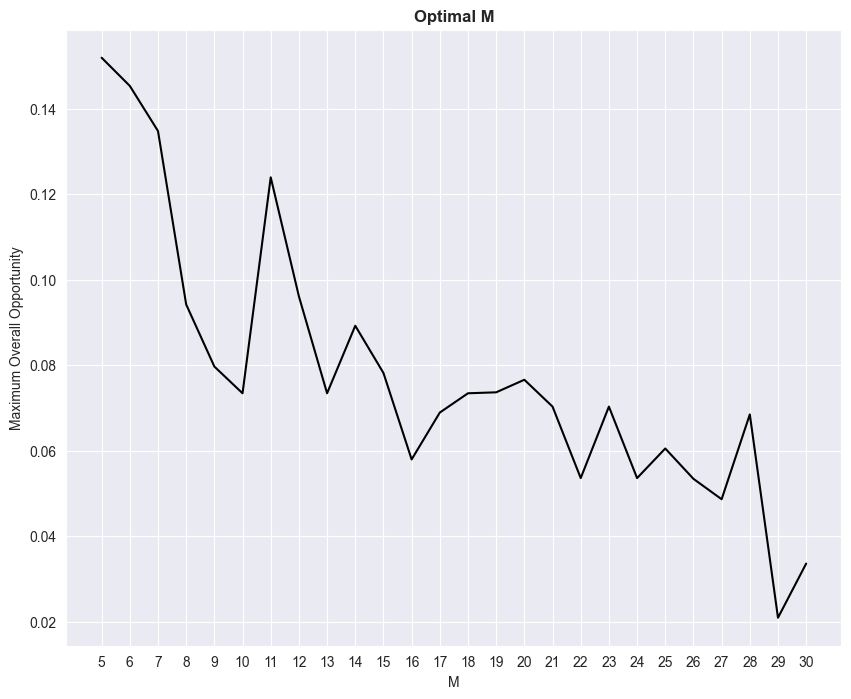

In [21]:
# set figure window
fig = plt.figure(figsize=(10,8))
# set axis
ax  = fig.add_subplot(111)
# time-series plot
ax.plot(temp[0], color = "black")
# x axis ticks and labels
ax.set_xlabel("M", fontsize=10)
ax.set_xticks(list(range(5, 31)))
# y axis labels
ax.set_ylabel("Maximum Overall Opportunity", fontsize=10)
# title
ax.set_title("Optimal M", fontsize=12, fontweight = "bold")

None

Based on the training data, $M = 5$ seems to be the optimal choice.
However, a low value of $M$ may accompany a lot of noise from the training data.

The graph above shows a peak in maximum overall investment opportunity when $M = 11$.

Therefore, $M$ was selected as 11 for the first model.

In [22]:
M = 11
print(">>> M was selected as: ", M)

>>> M was selected as:  11


<h4> <i> Selecting g: </i> </h4>

In [23]:
g_temp = temp[1][M - 1][temp[1][M - 1]['Validity'] == 'VALID'][['Opportunity', 'Enter', 'Exit']].\
    sort_values(by = ['Opportunity']).reset_index(drop = True)
g_temp

,Opportunity,Enter,Exit
0,0.005951,2021-05-03,2021-05-05
1,0.006903,2021-08-25,2021-08-26
2,0.007208,2021-10-28,2021-10-29
3,0.008698,2021-10-26,2021-10-27
4,0.008698,2021-10-27,2021-10-28
5,0.008844,2021-03-02,2021-03-04
6,0.009182,2021-05-11,2021-05-12
7,0.010661,2021-05-05,2021-05-11
8,0.011959,2021-03-08,2021-03-11
9,0.011959,2021-03-04,2021-03-08


With the selected $M$ as $11$, the minimum valid opportunity that was presented in the training data was observed.

$g$ was selected as this minimum opportunity rounded to 4 decimal points.

In [24]:
g = g_temp['Opportunity'][0].round(4)
print(">>> g was selected as: ", g)

>>> g was selected as:  0.006


<h4> <i> Selecting j: </i> </h4>

In [25]:
temp2 = accounting_analysis(df_clean.loc[train_dates[0]:train_dates[1]], M = M, g = g, j = 0, s = np.Inf,
                            return_full_data = True)
j_temp = temp2[temp2['Daily Return'] < 0].sort_values(by = ['Daily Return'])[[r'$z^M_t$', 'Daily Return']]
j_temp

,$z^M_t$,Daily Return
date,,
2021-09-27,-0.036614,-6.146856e-03
2021-08-13,0.022903,-4.842034e-03
2021-10-07,-0.019889,-4.810325e-03
2021-11-05,-0.023920,-4.303626e-03
2021-10-25,-0.010473,-4.152406e-03
...,...,...
2021-01-07,-0.024470,-4.058628e-05
2021-08-26,0.007427,-3.371105e-05
2021-04-23,0.024754,-2.172229e-05


With the selected $M = 11$ and $g = 0.006$, the training data was simulated for spread trade with $j = 0$ and
$s = \infty$. This means that after a position is open based on $|z| > g$ condition, we will not close it until the end
of the month.

After simulating the trades, the absolute value of $z$ where the daily return was negative were ordered and looked at.

$j$ is a parameter that provides a condition to protect the portfolio from loss. However, too high value of $j$ may
hinder profit from a future day's return on the portfolio. Given that you may only enter a position once per month at
most, the opportunity cost of a big $j$ value was huge.

Therefore, $j$ was selected as the mean of the 5 minimum absolute $z$ values, rounded to 4 decimal points, from the
training data simulation where the daily returns were negative.

In [26]:
j_temp = j_temp[[r'$z^M_t$']].abs().sort_values(by = [r'$z^M_t$']).head()
j = j_temp[r'$z^M_t$'].mean().round(4)
print(">>> j was selected as: ", j)
j_temp

>>> j was selected as:  0.0015


,$z^M_t$
date,
2021-03-05,0.000034
2021-05-17,0.000181
2021-05-07,0.001549
2021-05-18,0.002424
2021-05-19,0.003312


<h4> <i> Selecting s: </i> </h4>

In [27]:
temp3 = accounting_analysis(df_clean.loc[train_dates[0]:train_dates[1]], M = M, g = g, j = j, s = np.Inf,
                            return_full_data = True)

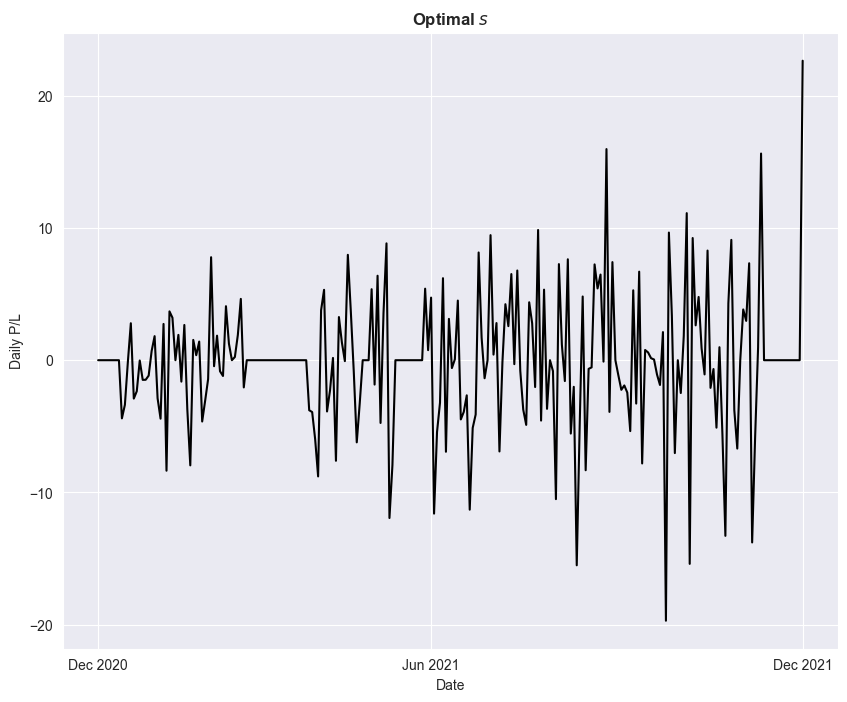

In [28]:
# set figure window
fig = plt.figure(figsize=(10,8))
# set axis
ax  = fig.add_subplot(111)
# time-series plot
ax.plot(temp3.index.values,
       temp3[r'Daily P/L'],
       color = 'black')
# x axis ticks and labels
ax.set_xlabel("Date", fontsize=10)
plt.xticks(['2020-12-22', '2021-06-04', '2021-12-01'], ['Dec 2020', 'Jun 2021', 'Dec 2021'])
# y axis labels
ax.set_ylabel("Daily P/L", fontsize=10)
# title
ax.set_title(r'Optimal $s$', fontsize=12, fontweight = "bold")
None

In [29]:
s_temp = temp3[[r'Daily P/L', 'Gross Cash']].sort_values(by = [r'Daily P/L']).head()
s_temp['Ratio'] = s_temp['Daily P/L'].abs()/s_temp['Gross Cash']
s_temp

,Daily P/L,Gross Cash,Ratio
date,,,
2021-09-27,-19.702724,1300.431158,0.015151
2021-08-13,-15.510754,1890.744399,0.008204
2021-10-07,-15.403062,1744.678159,0.008829
2021-11-05,-13.783528,2125.852935,0.006484
2021-10-25,-13.283434,1744.678159,0.007614


$s$ was selected by looking at the 5 worst daily losses, after simulating trades over training data with
$M = 11$, $g = 0.006$, and $j = 0.0015$.

The mean of the ratio between the loss and gross cash invested rounded to 4 decimal points was used.

In [30]:
s = s_temp['Ratio'].mean().round(4)
print(">>> s was selected as: ", s)

>>> s was selected as:  0.0093


<h4> <i> Trading Model 1: </i> </h4>

In [31]:
model_1 = accounting_analysis(df_clean, M = M, g = g, j = j, s = s, return_full_data= True)

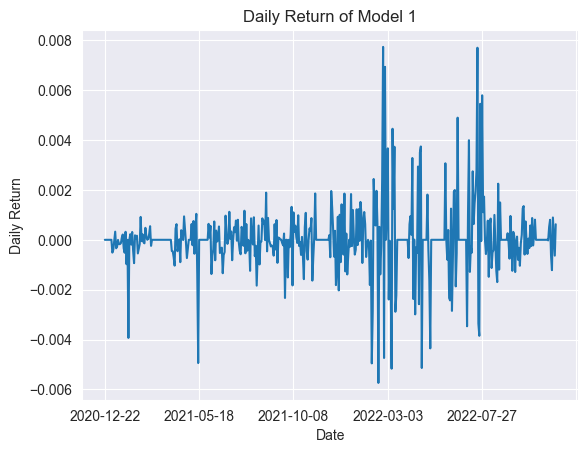

In [32]:
model_1['Daily Return'].plot()
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.title('Daily Return of Model 1')
None

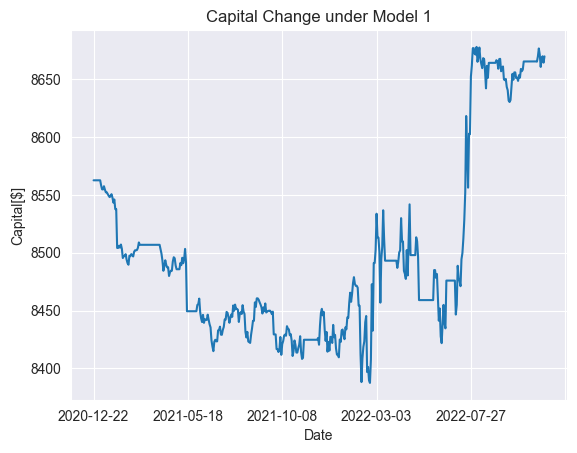

In [33]:
model_1['Capital'].plot()
plt.xlabel('Date')
plt.ylabel(r'Capital[\$]')
plt.title('Capital Change under Model 1')
None

<h2> 5. Correlation with Fama-French Factors </h2>

In [34]:
model_return = accounting_analysis(df_clean, M = M, g = g, j = j, s = s)
model_return.index = pd.to_datetime(model_return.index)
joined_df = pd.concat([Fama_French_df, model_return], axis = 1, join = 'inner')
joined_df = joined_df.loc['2021-01-01':end_date]
joined_df.corr()

,Mkt-RF,SMB,HML,RF,Daily Return
Mkt-RF,1.000000,-0.170979,-0.388138,-0.008847,-0.006721
SMB,-0.170979,1.000000,-0.031648,0.014887,-0.010135
HML,-0.388138,-0.031648,1.000000,0.006598,-0.033697
RF,-0.008847,0.014887,0.006598,1.000000,-0.011944
Daily Return,-0.006721,-0.010135,-0.033697,-0.011944,1.000000


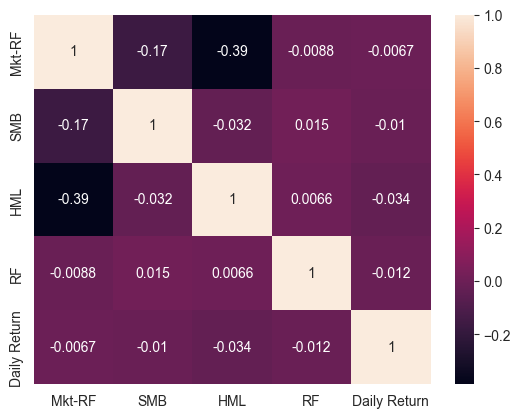

In [35]:
sns.heatmap(joined_df.corr(), annot = True)
None